In [1]:
from torch import nn
import matplotlib.pyplot as plt
from torchsummary import summary

import lightdde as dde
from essential import *
from qmodels import *

# Draw circuit

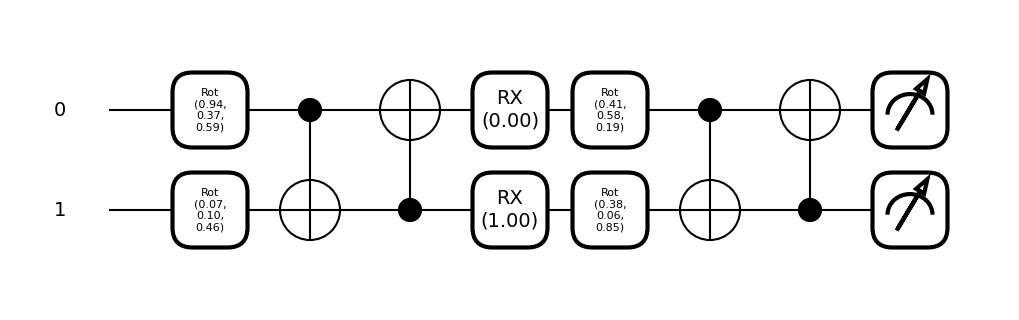

In [2]:
draw_circuit(*get_circuit(2, 1, 1))

# Inference

In [3]:
data = dde.data.PDEData(
    domain=domain,
    pde=pde,
    bcs=[boundary_condition_u, boundary_condition_v, boundary_condition_right_p],
    exact_solution=[u_func, v_func, p_func],
    num_domain=2601,
    num_bc=400,
    num_test=5000,
)

# Models

## classic model

In [4]:
net_c = ClassicNet2(in_dim=2, out_dim=3, hidden_dim=12, activation=nn.SiLU)

model_c = dde.Model(
    data=data,
    model=net_c,
    save_path="models/classic2_1000e_12h_silu/",
    log_every=10,
    save_every=100,
)

model_c.compile()

Loaded snapshot at epoch 1000


## FNN model

In [5]:
net_fnn = FNN()

model_fnn = dde.Model(
    data=data,
    model=net_fnn,
    save_path="models/FNN_1000e_tanh/",
    log_every=100,
    save_every=100,
)

model_fnn.compile()

Loaded snapshot at epoch 1000


## quantum model

In [6]:
net_q = QuantumNet(in_dim=2, out_dim=3, activation=nn.SiLU)

model_q = dde.Model(
    data=data,
    model=net_q,
    save_path="models/quantum_1000e_silu/",
    log_every=20,
    save_every=10,
)

model_q.compile()

Loaded snapshot at epoch 1000


In [7]:
summary(net_fnn, input_size=(1, 2), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]             150
              Tanh-2                   [-1, 50]               0
            Linear-3                   [-1, 50]           2,550
              Tanh-4                   [-1, 50]               0
            Linear-5                   [-1, 50]           2,550
              Tanh-6                   [-1, 50]               0
            Linear-7                   [-1, 50]           2,550
              Tanh-8                   [-1, 50]               0
            Linear-9                    [-1, 3]             153
Total params: 7,953
Trainable params: 7,953
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
-----------------------------------------------

# Predictions

In [8]:
num_points = 10000
x = model_q.data.domain.uniform_points(num_points)

y_exact = torch.hstack([u_func(x), v_func(x), p_func(x)])

In [9]:
y_fnn = model_fnn.predict(x)
y_classic = model_c.predict(x)
y_quantum = model_q.predict(x)

Executed in 0.04 sec.
Executed in 0.02 sec.


In [12]:
y_fnn.shape, y_classic.shape, y_quantum.shape,

(torch.Size([1200, 3]), torch.Size([1200, 3]), torch.Size([1200, 3]))

# Loss of exact solution

In [8]:
num_points = 10000
x = model_q.data.domain.uniform_points(num_points)
x.requires_grad_()

y_exact = torch.hstack([u_func(x), v_func(x), p_func(x)])

In [9]:
momentum_x, momentum_y, continuity = pde(x, y_exact)

In [10]:
momentum_x.shape

torch.Size([10092, 1])

In [11]:
momentum_y.abs().max()

tensor(4.7684e-07, grad_fn=<MaxBackward1>)

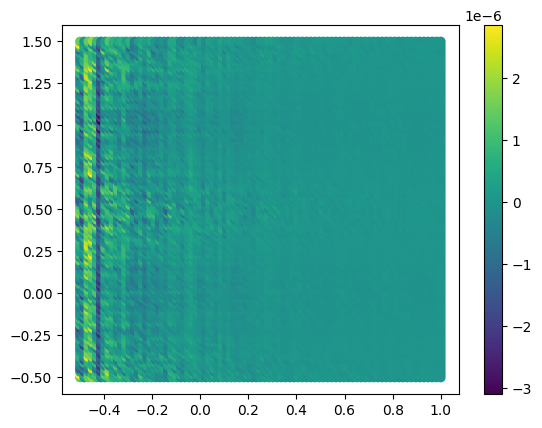

In [19]:
plt.scatter(x[:, 0].detach(), x[:, 1].detach(), c=momentum_x.detach())
plt.colorbar()

# Plotting

In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rcParams['font.family'] = 'serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif'] = cmfont.get_name()
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.unicode_minus'] = False

## For thesis

/tmp/ipykernel_366/12339640.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharex=True)
/tmp/ipykernel_366/12339640.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cax = divider.append_axes("right", size="5%", pad=0.05)
/tmp/ipykernel_366/12339640.py:10: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig.colorbar(mappable, cax=cax)


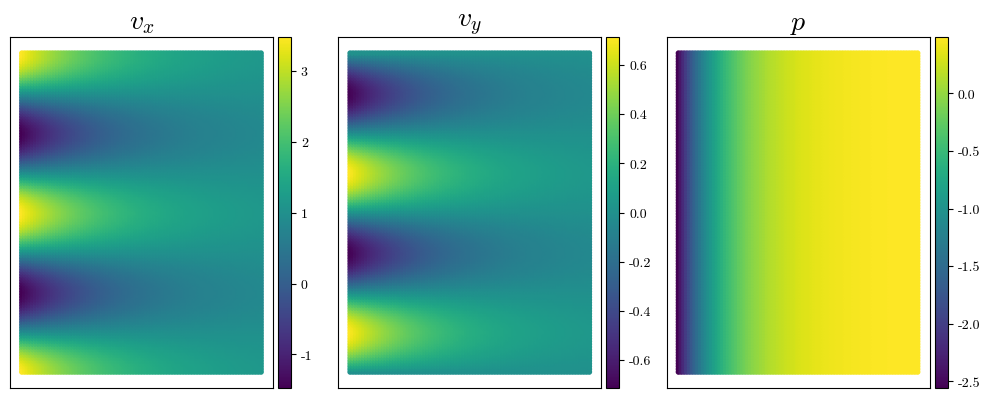

In [28]:
# Plot exact solution
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharex=True)
titles = [r"$v_x$", r"$v_y$", r"$p$"]
for i in range(3):
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)

    mappable = axs[i].scatter(x[:, 0], x[:, 1], c=y_exact[:, i], s=10)
    axs[i].set_title(titles[i], fontsize=20)
    fig.colorbar(mappable, cax=cax)

for i in range(3):
    axs[i].tick_params(
        axis='both', 
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )
    axs[i].set_aspect("equal")

plt.tight_layout()
plt.savefig("exact_sol.png")
plt.show()

/tmp/ipykernel_366/2490122654.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(10, 10), sharex=True)


NameError: name 'y_quantum' is not defined

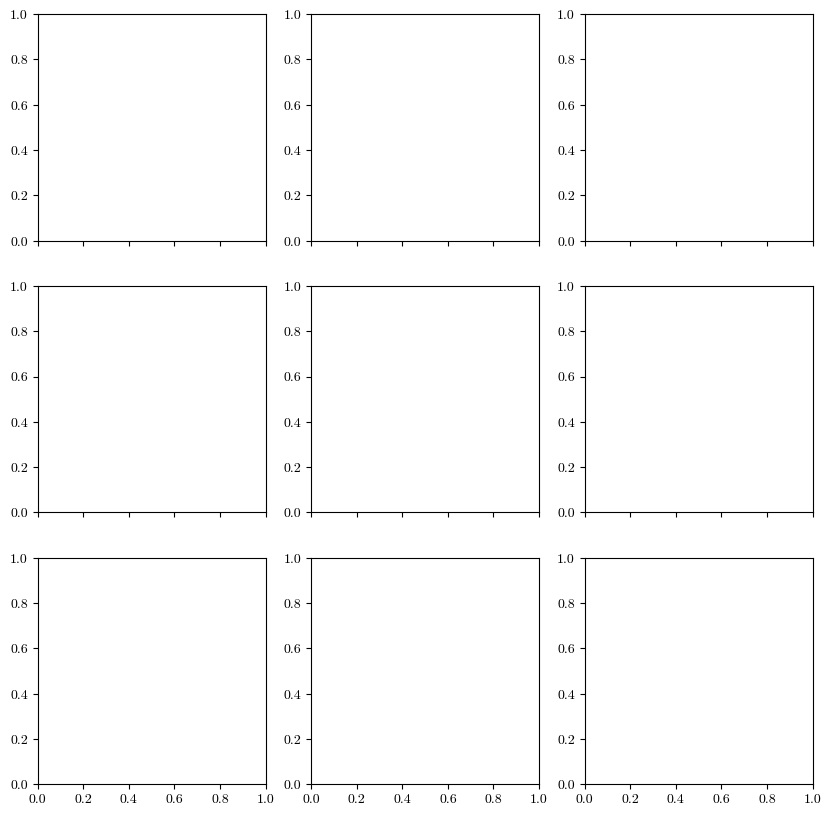

In [27]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(10, 10), sharex=True)
titles = ["FNN", "Classic", "Quantum"]
ys = [y_fnn, y_classic, y_quantum]

# u
for i in range(3):
    divider = make_axes_locatable(axs[0, i])
    cax = divider.append_axes("right", size="5%", pad=0.05)

    mappable = axs[0, i].scatter(x[:, 0], x[:, 1], c=ys[i][:, 0], s=35)
    axs[0, i].set_title(titles[i], fontsize=20)
    fig.colorbar(mappable, cax=cax)


# v
for i in range(3):
    divider = make_axes_locatable(axs[1, i])
    cax = divider.append_axes("right", size="5%", pad=0.05)

    mappable = axs[1, i].scatter(x[:, 0], x[:, 1], c=ys[i][:, 1], s=35)
    axs[0, i].set_title(titles[i], fontsize=20)
    fig.colorbar(mappable, cax=cax)

# p
for i in range(3):
    divider = make_axes_locatable(axs[2, i])
    cax = divider.append_axes("right", size="5%", pad=0.05)

    mappable = axs[2, i].scatter(x[:, 0], x[:, 1], c=ys[i][:, 2], s=35)
    axs[0, i].set_title(titles[i], fontsize=20)
    fig.colorbar(mappable, cax=cax)
    
for i in range(3):
    for j in range(3):
        axs[i, j].tick_params(
            axis='both', 
            which='both',
            bottom=False,
            left=False,
            labelbottom=False,
            labelleft=False,
        )
        axs[i, j].set_aspect("equal")

axs[0, 0].set_ylabel(r"$v_x$", fontsize=20)
axs[1, 0].set_ylabel(r"$v_y$", fontsize=20)
axs[2, 0].set_ylabel(r"$p$", fontsize=20)

plt.tight_layout()
plt.savefig("fnn_c_q_comparison.pdf")
plt.show()

## Other

Executed in 0.03 sec.


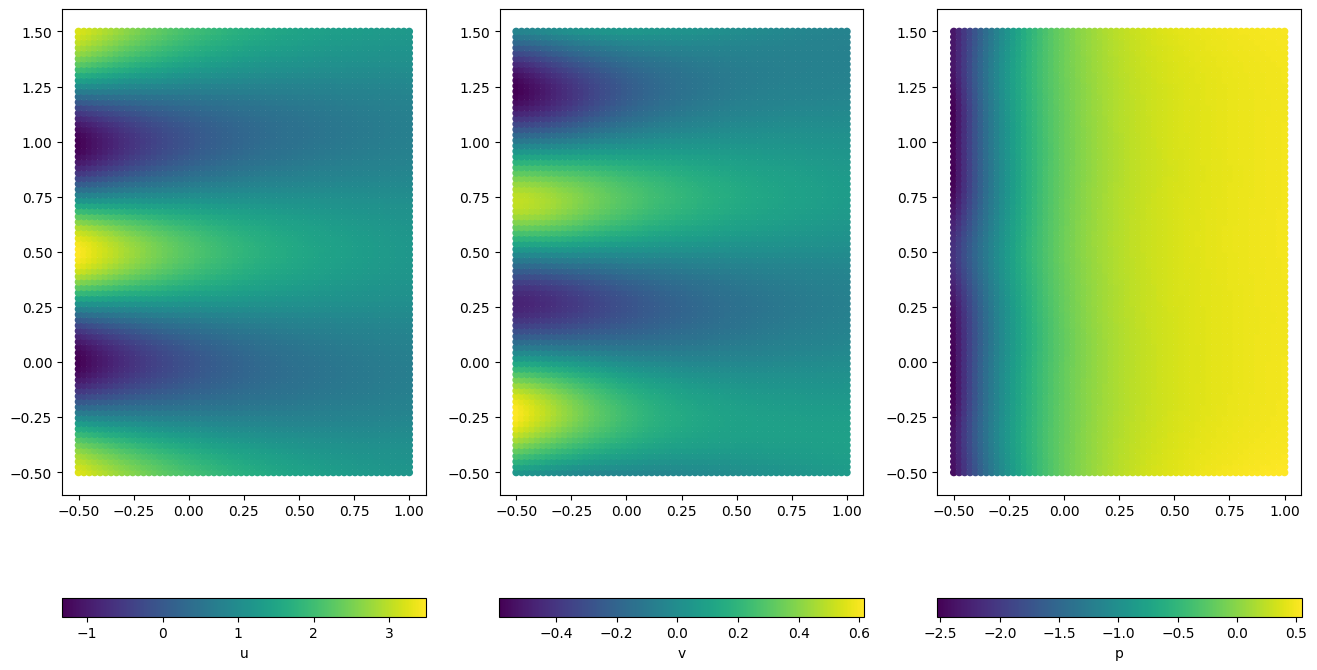

''

In [10]:
dde.scatter_plot(model_fnn, s=20)
;

## Comparison pretty plot for QTML

Executed in 31.61 sec.
Executed in 0.00 sec.


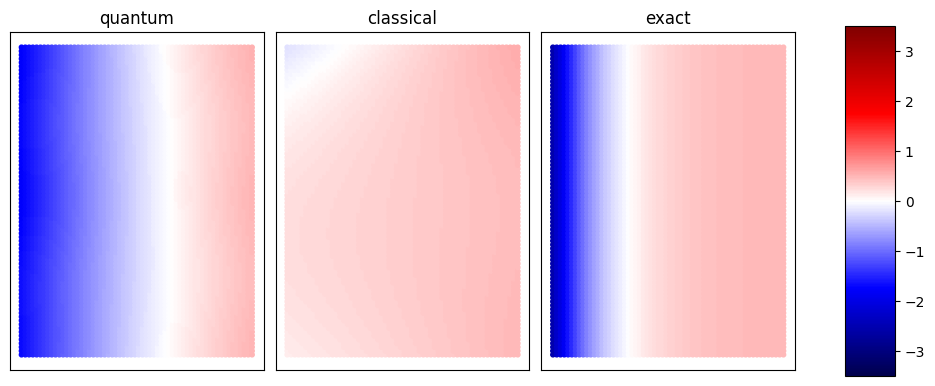

In [8]:
x, ys = dde.compare_plot([model_q, model_c], num_points=5000, component=2, s=10, solution_fn=[u_func, v_func, p_func])

# Load csv loss

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

## FNN

In [30]:
df_fnn = pd.read_csv("models/FNN_1000e_tanh/log.csv", index_col="epoch")
df_fnn.tail()

,loss_train,u_err,v_err,p_err
epoch,,,,
920,0.030747,0.132076,0.052107,0.123103
940,0.029206,0.130383,0.050884,0.121484
960,0.042764,0.124476,0.049088,0.113421
980,0.026700,0.125740,0.049122,0.116596
1000,0.025400,0.124740,0.047245,0.116464


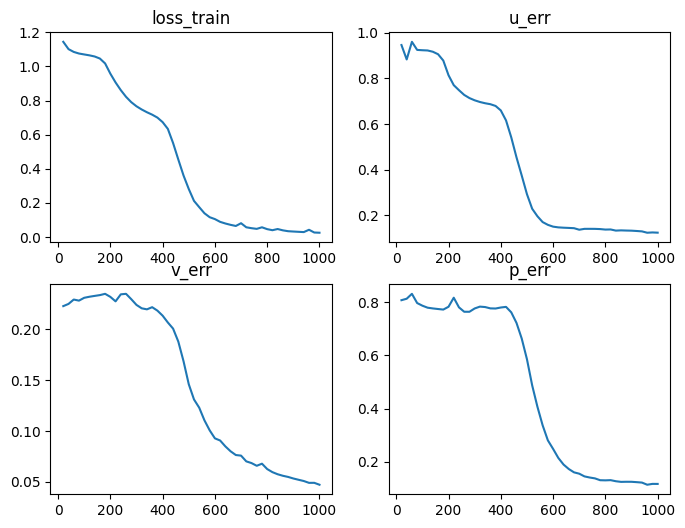

In [12]:
errs = ["loss_train", "u_err", "v_err", "p_err"]

plt.figure(figsize=(8, 6))
for i, err in enumerate(errs):
    plt.subplot(2, 2, i+1)
    plt.plot(df_fnn[err])
    plt.title(err)
plt.show()

## Q and C

In [31]:
df_c_silu = pd.read_csv("models/classic2_1000e_12h_silu/log.csv", index_col="epoch")
df_q_silu = pd.read_csv("models/quantum_1000e_silu/log.csv", index_col="epoch")

In [32]:
df_q_silu.tail()

,loss_train,u_err,v_err,p_err
epoch,,,,
920,0.293020,0.625606,0.144941,0.442138
940,0.289136,0.629557,0.144635,0.451570
960,0.286598,0.631317,0.144542,0.457385
980,0.284875,0.631552,0.144566,0.460248
1000,0.283665,0.630875,0.144668,0.461145


In [33]:
df_c_silu.tail()

,loss_train,u_err,v_err,p_err
epoch,,,,
920,0.907251,0.777093,0.227705,0.803481
940,0.904605,0.776742,0.227026,0.800844
960,0.901405,0.776386,0.226278,0.797608
980,0.897574,0.776023,0.225558,0.793929
1000,0.893168,0.775649,0.224984,0.790077


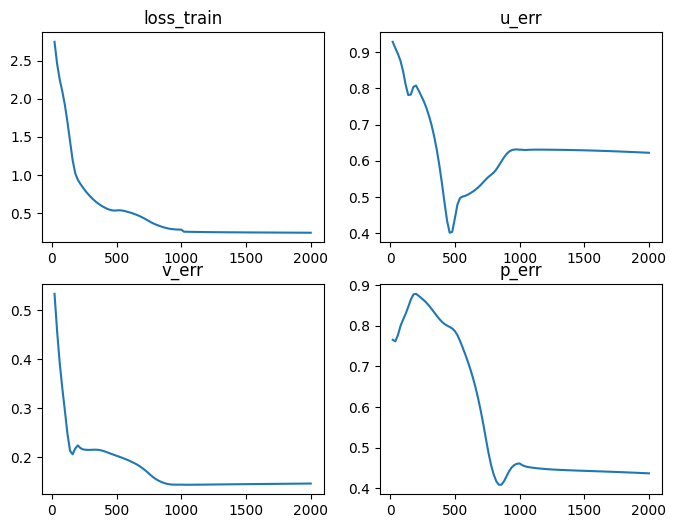

In [16]:
errs = ["loss_train", "u_err", "v_err", "p_err"]

plt.figure(figsize=(8, 6))
for i, err in enumerate(errs):
    plt.subplot(2, 2, i+1)
    plt.plot(df_q_silu[err])
    plt.title(err)
plt.show()